In [1]:
import random
import math
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)

In [2]:
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

In [3]:
m = n = np.random.randint(2, 3)

def generate_random_data_for_maxqp(n):
    m = n 
    # Линейные ограничения для допустимой области
    A = np.random.rand(m, n)
    b = 10*np.ones(m) #np.floor(1/np.random.rand(m))
    M = np.random.rand(m, n)
    Q = np.dot(M, M.T) # симметричная положительно-полуопределенная
    c = np.random.rand(n) 
    return A, Q, c, b


A, Q, c, b = generate_random_data_for_maxqp(n)
A, Q, c, b

(array([[0.81, 0.01],
        [0.13, 0.38]]),
 array([[0.04, 0.15],
        [0.15, 0.69]]),
 array([0.38, 0.57]),
 array([10., 10.]))

Попробуем реализовать методы из https://www.researchgate.net/publication/221451749_Linear_Reformulations_of_Integer_Quadratic_Programs/

![](./.maximum-quadratic-programming.ipynb.upload/bbl-idea.drawio.svg) 11

![](./.maximum-quadratic-programming.ipynb.upload/bbl.png)

In [4]:
def get_model_bbl(A, b, Q, c):
    m = pyo.ConcreteModel()

    m.m, m.n = A.shape

    # на всякий случай, возьмем с собой
    m.A = A
    m.Q = Q
    m.b = b
    m.c = c

    m.I = range(m.m)
#    m.J = range(m.n)

    
    upper_bound_x = math.ceil(max([b[i] / min([m.A[i, j] for j in m.I]) for i in m.I]))
    
    m.u = upper_bound_x #16 #256
    bin_len = math.ceil(math.log(m.u)/math.log(2))

    m.K = range(bin_len)

    m.x = pyo.Var(m.I, domain=pyo.NonNegativeIntegers)
    @m.Constraint(m.I)
    def не_больше(m, i):
        return sum(A[i, j] * m.x[j] for j in m.I) <= b[i]

    m.t_ik = pyo.Var(m.I, m.K, domain=pyo.Binary)

    @m.Constraint(m.I)
    def t_будет_бинарным_разложением_x(m, i):
        return m.x[i] == sum(2**k * m.t_ik[i, k] for k in m.K)

    # Бинарное произведение y_ikjl = t_ik * t_jl
    m.y_ikjl = pyo.Var(m.I, m.K, m.I, m.K, domain=pyo.Binary)

    @m.Constraint(m.I, m.K, m.I, m.K, [7, 8, 9, 10, 11, 13])
    def y_ikjl_constraint_A(m, i, k, j, l, c):
        if c == 7 and m.Q[i,j] < 0:
            return m.y_ikjl[i, k, j, l] <= m.t_ik[i, k]
        if c == 8 and m.Q[i,j] < 0:
            return m.y_ikjl[i, k, j, l] <= m.t_ik[j, l]
        if c == 9 and m.Q[i,j] > 0:
            return m.y_ikjl[i, k, j, l] >= m.t_ik[i, k] + m.t_ik[j, l] - 1
        if c == 10 and m.Q[i,j] > 0:
            return m.y_ikjl[i, k, j, l] >= 0
        if c == 11 and m.Q[i,j] != 0 and i < j:
            return m.y_ikjl[i, k, j, l] == m.y_ikjl[j, l, i, k]
        if c == 13 and m.Q[i,i] != 0 and k < l:
            return m.y_ikjl[i, k, i, l] == m.y_ikjl[i, l, i, k]
        return pyo.Constraint.Skip

    @m.Constraint(m.I, m.K, [12])
    def y_ikjl_constraint_B(m, i, k, c):
        if c == 12 and m.Q[i,i] != 0:
            return m.y_ikjl[i, k, i, k] == m.t_ik[i, k]
        return pyo.Constraint.Skip

    @m.Objective(sense=pyo.maximize)
    def сложная_побитовая_сумма(m):
        return sum( Q[i, j] * sum(2**(k+l) * m.y_ikjl[i, k, j, l] for k in m.K for l in m.K ) for i in m.I for j in m.I)

    return m

m = get_model_bbl(A, b, Q, c)
m.u
#m.pprint()

1056

In [5]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3302336.2440436
  Upper bound: 3302336.2440436
  Number of objectives: 1
  Number of constraints: 162
  Number of variables: 182
  Number of binary variables: 506
  Number of integer variables: 508
  Number of nonzeros: 182
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.15
  Wallclock time: 0.09
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statisti

In [6]:
#print_solution(m)
print(m.x.extract_values())

{0: 0.0, 1: 26.0}


In [7]:
[m.x[i].value for i in m.I]

[0.0, 26.0]

### Упражнения
* Найти кое-что пропущеное в постановке `get_model_bbl` (мелочь, так, на внимательность)
#### Разобраться в ограничениях BBL
* Написать комментарии зачем они.
* Можно уменьшить их число?

#### Сделать отдельно линеаризацию BIL
т.е. написать функцию `get_model_bil` «binary integer linerization» из [статьи](https://www.researchgate.net/publication/221451749_Linear_Reformulations_of_Integer_Quadratic_Programs/)

# А что с библиотеками для решения квадратичного программирования?

In [8]:
import picos as pic
import matplotlib.pyplot as plt
import scipy
import cvxopt as cvx
import cvxpy as cp


### Простой пример с CVXPY

Не Pyomo, но схожий язык.

Оптимизационные переменные

In [9]:
x = cp.Variable()
y = cp.Variable()

Ограничения

In [10]:
constraints =  [x + y == 1,
                x - y >= 1]

Целевая функция

In [11]:

obj = cp.Minimize((x - y)**2)


Решаем

In [12]:
prob = cp.Problem(obj, constraints)
prob.solve() 
prob.status, prob.value, x.value, y.value

('optimal', 1.0, array(1.), array(0.))

In [13]:
Q = np.array([[0, 1], [1, 0]])
Q

array([[0, 1],
       [1, 0]])

In [14]:
y = cp.Variable(2, integer=True)
obj = cp.quad_form(y, Q)
constraits = [y >= -2, 
              y <=  2]
prob = cp.Problem(cp.Maximize(obj), constraits)
# prob = cp.Problem(cp.Minimize(obj), constraits)
print(prob)
prob.solve() #solver=cp.SCIP

maximize QuadForm(var45, [[0.00 1.00]
 [1.00 0.00]])
subject to -2.0 <= var45
           var45 <= 2.0


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var45, [[0.00 1.00]
 [1.00 0.00]])

Визуализируем эту матрицу

In [ ]:
n_points = 5
u = np.linspace(-2, 2, n_points)
u

array([-2., -1.,  0.,  1.,  2.])

In [ ]:
x1, x2 = np.meshgrid(u, u)
x1, x2


(array([[-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.]]),
 array([[-2., -2., -2., -2., -2.],
        [-1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  2.,  2.]]))

In [ ]:
all_x = list(np.array([x1,x2]) for x1, x2 in zip(np.ravel(x1), np.ravel(x2)))
all_x

[array([-2., -2.]),
 array([-1., -2.]),
 array([ 0., -2.]),
 array([ 1., -2.]),
 array([ 2., -2.]),
 array([-2., -1.]),
 array([-1., -1.]),
 array([ 0., -1.]),
 array([ 1., -1.]),
 array([ 2., -1.]),
 array([-2.,  0.]),
 array([-1.,  0.]),
 array([0., 0.]),
 array([1., 0.]),
 array([2., 0.]),
 array([-2.,  1.]),
 array([-1.,  1.]),
 array([0., 1.]),
 array([1., 1.]),
 array([2., 1.]),
 array([-2.,  2.]),
 array([-1.,  2.]),
 array([0., 2.]),
 array([1., 2.]),
 array([2., 2.])]

In [ ]:
Z =  np.array([ np.dot(x.T, np.dot(Q, x)) for x in all_x])
Z = Z.reshape(x1.shape)
Z

array([[ 8.,  4.,  0., -4., -8.],
       [ 4.,  2.,  0., -2., -4.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-4., -2.,  0.,  2.,  4.],
       [-8., -4.,  0.,  4.,  8.]])

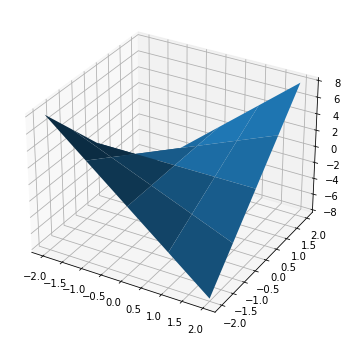

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.figure()
ax.plot_surface(x1, x2, Z)

Увы, библиотеки работают с выпуклыми-коническими функциями и ограничениями.

In [ ]:
A, _, c, b = generate_random_data_for_maxqp(2)
A, Q, c, b


(array([[0.24, 0.5 ],
        [0.06, 0.13]]),
 array([[0, 1],
        [1, 0]]),
 array([0.57, 0.17]),
 array([10., 10.]))

In [ ]:
m = get_model_bbl(A, b, Q, c)
solver.solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 130050.0
  Upper bound: 130050.0
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Number of binary variables: 144
  Number of integer variables: 146
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and 

In [ ]:
[m.x[j].value for j in m.x]

[0.0, 0.0]

##  Упражнения
* Сделать генерацию данных подходящих для решения библиотеками cvxpy, cvxopt, picos (коническое-выпуклое) и прорешать и этими библиотеками, и через линеаризацию, сравнить, возможно найти ошибки. (достаточно добавить еще одну библиотеку, не обязательно перебирать все, или даже для имеющихся cvxpy это проделать)



* Кстати,  pyomo тоже умеет в квадратичное программирование, см. например [1](https://github.com/Pyomo/pyomo/blob/main/examples/pyomo/quadratic/example4.py), но не факт что со всеми солверами — тоже надо потестировать.